<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GA Capstone: Fake News Classifier

Author: Tan Kai Yong Alvin

# Notebook 1-1: Data Cleaning and Exploratory Data Analysis (EDA)

## Background / Problem Statement

In recent years, we have witnessed a rise in fake news. The dissemination of this type of news poses a serious threat to cohesion and social well-being as it fosters political polarization and the distrust amongst people in the community. During the recent Covid-19 pandaemic, spreading of falsehood on the efficacy of vaccination as well as its long term side effects had also severely undermined country's effort to counter Covid-19 as it spread fear and uncertainty amongst people leading to people shying away from taking up vaccination.

The large volume of fake news that is disseminated through social media also made manual classification and identification of fake news increasingly difficult. Hence, the aim of this project is to develop a Fake News Classifier model that can enable the automation of fake news detection.

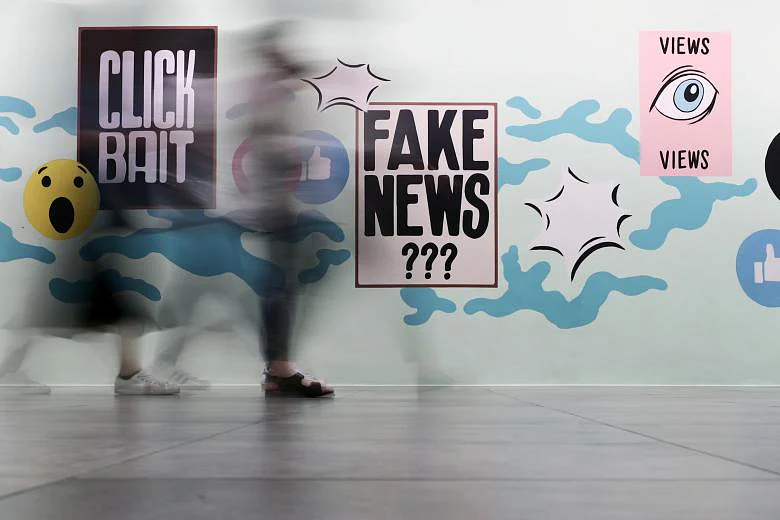 Image source: https://www.straitstimes.com/tech/tech-news/many-in-singapore-confident-they-can-spot-fake-news-but-may-not-actually-be-able-to-study

## Content

The project comprises of the following code notebooks:

* Notebook 1-1: Introduction and Data Preparation.

* Notebook 1-2: Application of Open AI GPT-2 for Generation of Fake News (Unseen data)

* Notebook 2-1: Modeling (Baseline Model)

* Notebook 2-2: Modeling (Pycaret)

* Notebook 2-3: Modeling (LSTM with GloVe Word Embedding)

* Notebook 3: Sentiment Analysis and Conclusion

* Notebook 4: Deployment (Experimentation)

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# preprocessing of data
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # split our data and run hyperparameter search

pd.options.display.max_colwidth = 400

### Import Dataset

The dataset comprises of two CSV file. The first file 'True-CSV'contains 21,417 rows of 'Real News' and the second file 'Fake_csv' contains 23,481 of 'Fake News'. Both datasets were obtained from [Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?search=source). 

In [2]:
real_df = pd.read_csv('./datasets/True.csv')
fake_df = pd.read_csv('./datasets/Fake.csv')

## Data Cleaning

### Real News

In [3]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [4]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packa...",politicsNews,"December 29, 2017"


In [5]:
# convert 'date' column to datetime format
real_df['date'] = pd.to_datetime(real_df['date'])

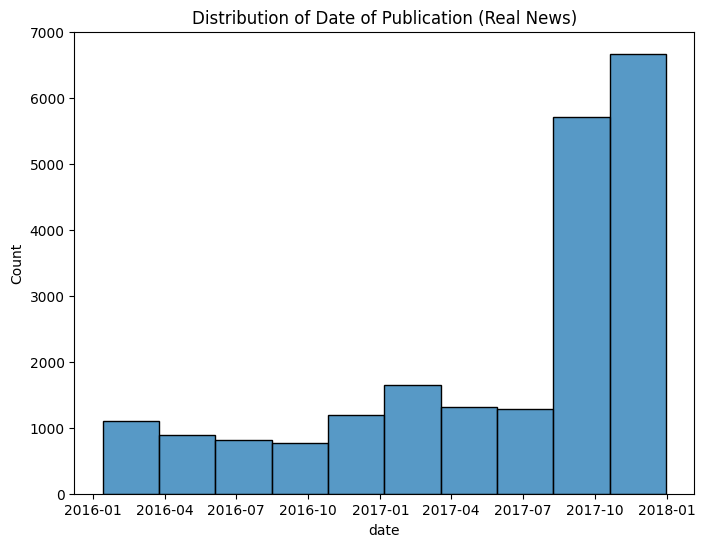

In [6]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 6))
sns.histplot(x=real_df['date'], bins=10)
plt.title('Distribution of Date of Publication (Real News)', fontsize=12);

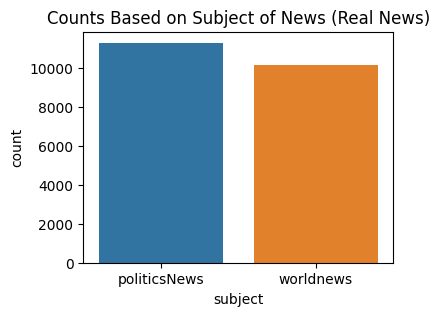

In [7]:
#plot a count plot on the type of news
plt.figure(figsize=(4, 3))
sns.countplot(x ='subject', data = real_df)
plt.title('Counts Based on Subject of News (Real News)', fontsize=12);

There were only 2 subjects namely 'politicsNews' and 'worldnews' featured in the real news dataset.

In [8]:
# check for duplicates
real_df.duplicated().value_counts()

False    21211
True       206
dtype: int64

In [9]:
# drop duplicates
real_df.drop_duplicates(inplace = True)

In [10]:
# Reset index
real_df.reset_index(drop=True, inplace=True)
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21211 entries, 0 to 21210
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21211 non-null  object        
 1   text     21211 non-null  object        
 2   subject  21211 non-null  object        
 3   date     21211 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 663.0+ KB


In [11]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",politicsNews,2017-12-31
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...",politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...",politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packa...",politicsNews,2017-12-29


### Fake News

In [12]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [13]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dis...",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained...",News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt....",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf includin...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the peaceful coexistence of two states within mutually agreed and internationally recognized borders. We ...,News,"December 25, 2017"


In [14]:
# by setting the parameter to "coerce", we will set unappropriate values to NaT (null)
# NaT is the representation for Not-a-Time, a value that can be stored in a datetime array to indicate an unknown or missing datetime value.
fake_df['date'] = pd.to_datetime(fake_df['date'], errors='coerce')

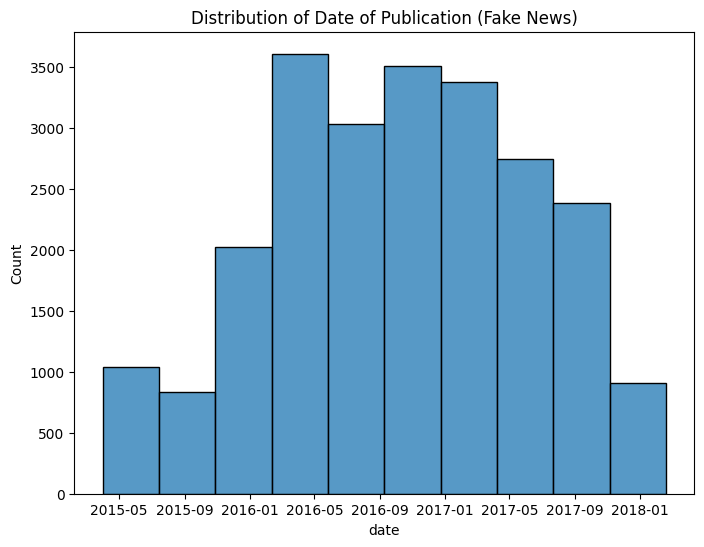

In [15]:
# Plot distribution of submissions against time.
plt.figure(figsize=(8, 6))
sns.histplot(x=fake_df['date'], bins=10)
plt.title('Distribution of Date of Publication (Fake News)', fontsize=12);

Date of posting of fake news is from May 2015 to Jan 2018. 

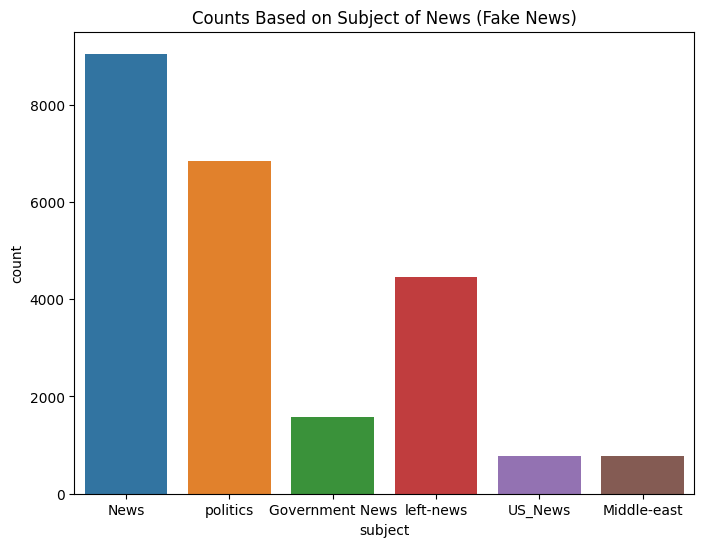

In [16]:
#plot a count plot on the type of news
plt.figure(figsize=(8, 6))
sns.countplot(x ='subject', data = fake_df)
plt.title('Counts Based on Subject of News (Fake News)', fontsize=12);

6 subjects namely 'News', 'politics', 'Government News', 'left news', 'US_News' and Middle-east' news were featured in the fake news dataset. There are more varieties of news subject in the fake news dataset.

In [17]:
# check for counts of duplicates in dataset
fake_df.duplicated().value_counts()

False    23478
True         3
dtype: int64

In [18]:
# drop duplicates
fake_df.drop_duplicates(inplace = True)

In [19]:
fake_df.reset_index(drop=True, inplace=True)
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23478 entries, 0 to 23477
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23478 non-null  object        
 1   text     23478 non-null  object        
 2   subject  23478 non-null  object        
 3   date     23468 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 733.8+ KB


In [20]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dis...",News,2017-12-31
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained...",News,2017-12-31
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt....",News,2017-12-30
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf includin...",News,2017-12-29
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the peaceful coexistence of two states within mutually agreed and internationally recognized borders. We ...,News,2017-12-25


## Exploratory Data Analysis (EDA)

### EDA on Word Count

In [21]:
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

def plot_dist(df, feature, title, bins):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(10, 10))
    grid = gridspec.GridSpec(ncols= 1,nrows=2, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, 0])

    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.histplot(data =df, x=feature, ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=bins))
    #add horizontal line at mean value of y
    ax1.axvline(x=np.mean(df[feature]), color='green', linestyle='--', linewidth=3, label='Avg')

    # Customizing the Box Plot.
    ax2 = fig.add_subplot(grid[1, 0])
    # Set title.
    ax2.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(y=feature, data=df, ax=ax2)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=bins))
    
    plt.suptitle(f'{title}', fontsize=12)

#### Word Count Based on title (Headline) only

In [22]:
# number of words (title)
real_df['wordcount_title'] = real_df['title'].apply(lambda txt: len(txt.split()))
fake_df['wordcount_title'] = fake_df['title'].apply(lambda txt: len(txt.split()))

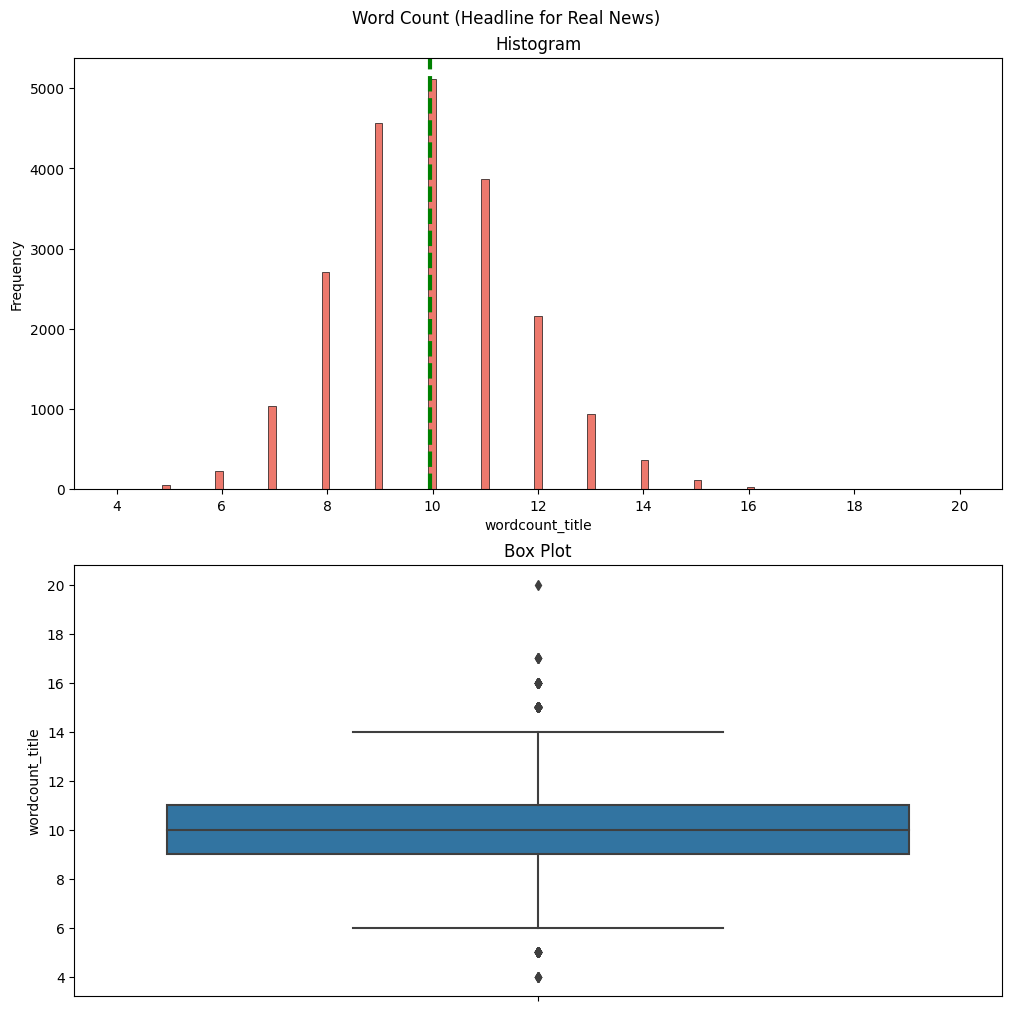

In [23]:
# distribution of word count for real news
plot_dist(real_df, 'wordcount_title', 'Word Count (Headline for Real News)', 10)

In [24]:
real_df['wordcount_title'].mean()

9.951581726462685

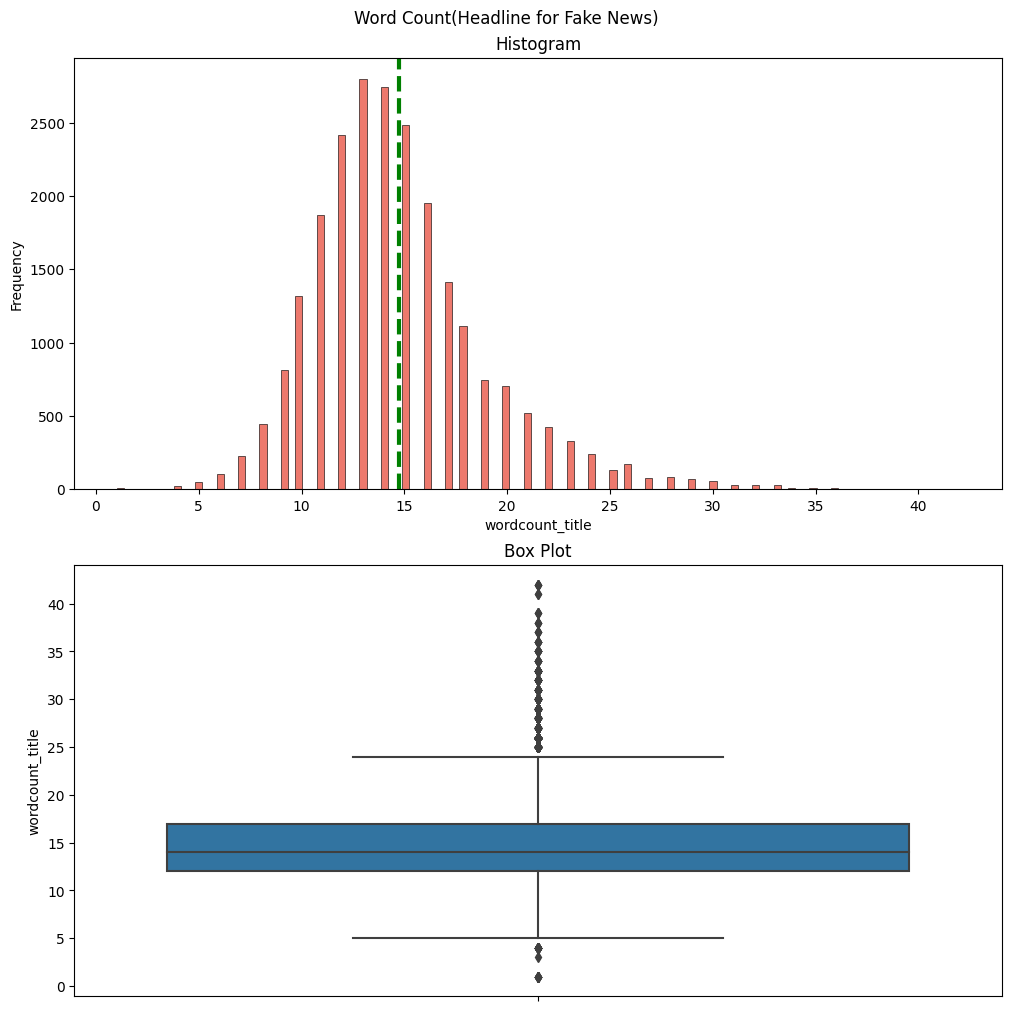

In [25]:
plot_dist(fake_df, 'wordcount_title', 'Word Count(Headline for Fake News)', 10)

In [26]:
fake_df['wordcount_title'].mean()

14.732387767271488

In [27]:
# number of words (text)
real_df['wordcount_text'] = real_df['text'].apply(lambda txt: len(txt.split()))
fake_df['wordcount_text'] = fake_df['text'].apply(lambda txt: len(txt.split()))

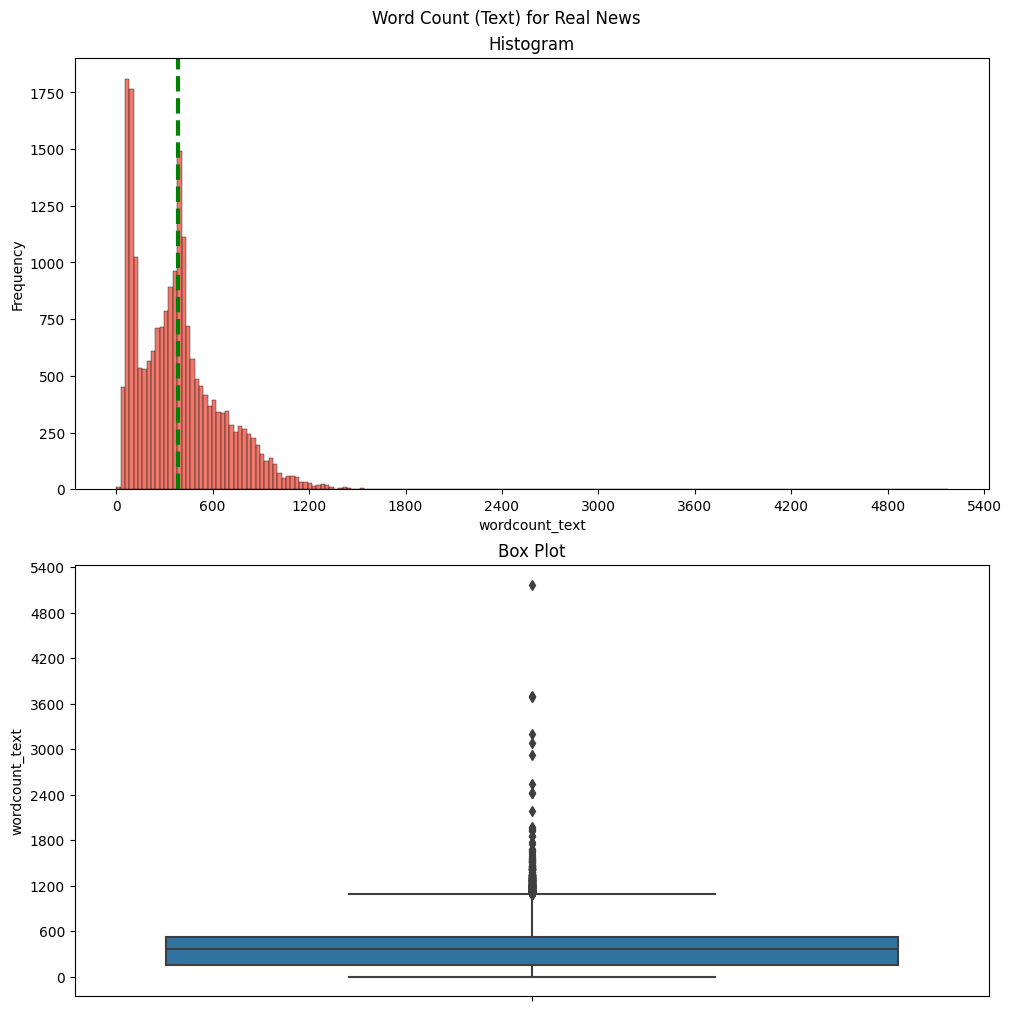

In [28]:
# distribution of word count for real news
plot_dist(real_df, 'wordcount_text', 'Word Count (Text) for Real News', 10)

In [29]:
real_df['wordcount_text'].mean()

384.7574843241714

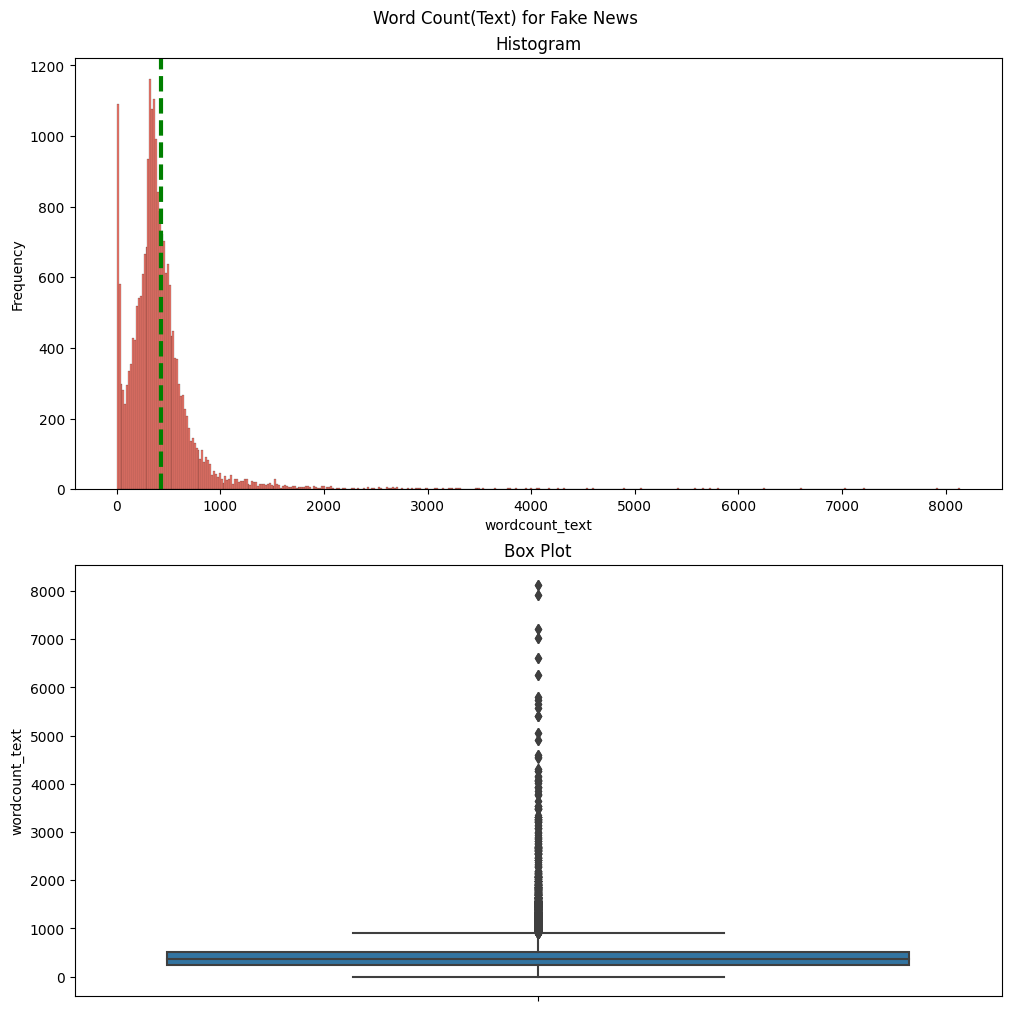

In [30]:
plot_dist(fake_df, 'wordcount_text', 'Word Count(Text) for Fake News', 10)

In [31]:
fake_df['wordcount_text'].mean()

423.2241673055627

### EDA for Top Words

In this section,'english' stopwords as defined in the NLTK library will be dropped from the text data. Top occurring words and obvious words that can easily be linked to 'real' and 'fake' news classification will be reviewed and dropped. 

In [32]:
# Print English stopwords list from nltk library.
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### Real News

In [33]:
# unigram

In [34]:
# Instantiate a CountVectorizer, excluding stopwords
cvec = CountVectorizer(stop_words='english', min_df = 0.01)

In [35]:
X_real = real_df['text']
X_real_cvec = cvec.fit_transform(X_real)

In [36]:
X_real_df = pd.DataFrame(X_real_cvec.toarray(), columns=cvec.get_feature_names())

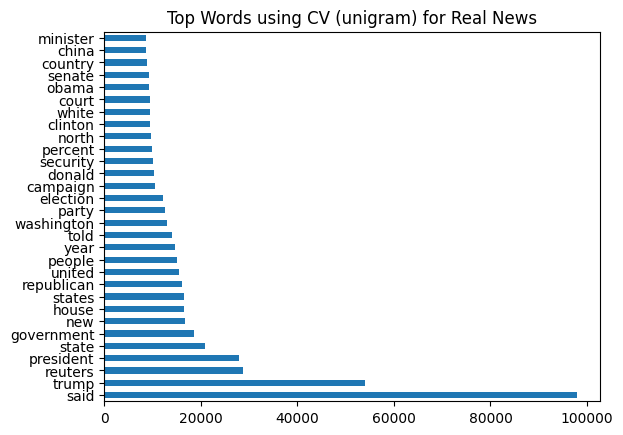

In [37]:
# plot top occuring words in a horizontal bar chart
X_real_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (unigram) for Real News', fontsize=12);

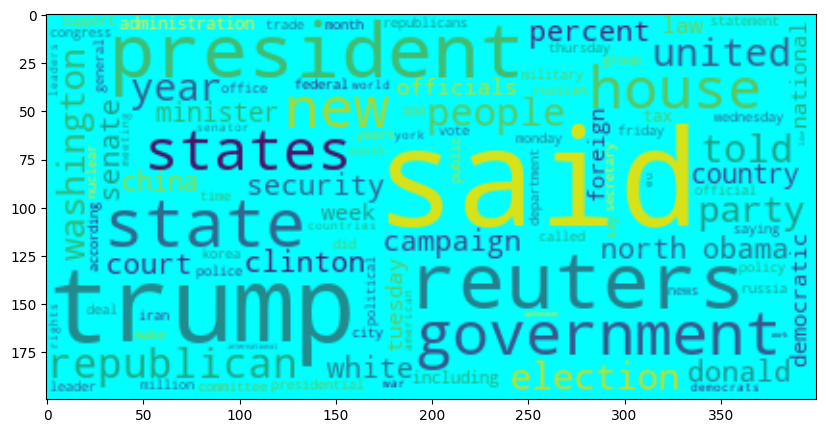

In [38]:
X_real_df.T.sum(axis=1)
Cloud = WordCloud(background_color="cyan", max_words=100).generate_from_frequencies(X_real_df.T.sum(axis=1))
plt.figure(figsize=(12,5))
plt.imshow(Cloud, interpolation='bilinear');

In [39]:
# bigrams

In [40]:
cvec_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english', min_df =0.01)

In [41]:
X_real = real_df['text']
X_real_cvec_bi = cvec_bigram.fit_transform(X_real)

In [42]:
X_real_bi_df = pd.DataFrame(X_real_cvec_bi.toarray(), columns=cvec_bigram.get_feature_names())

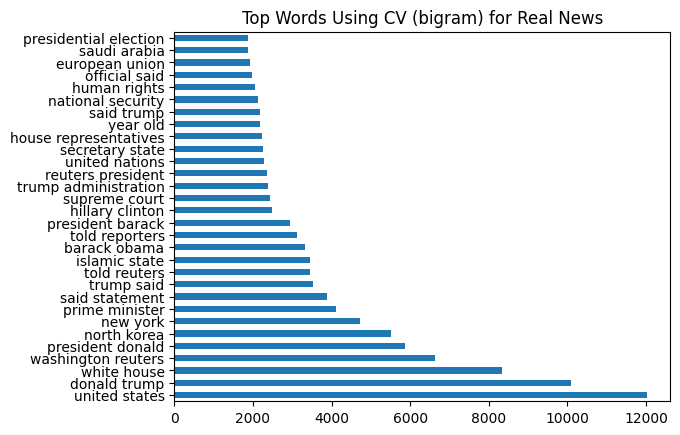

In [43]:
X_real_bi_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words Using CV (bigram) for Real News');

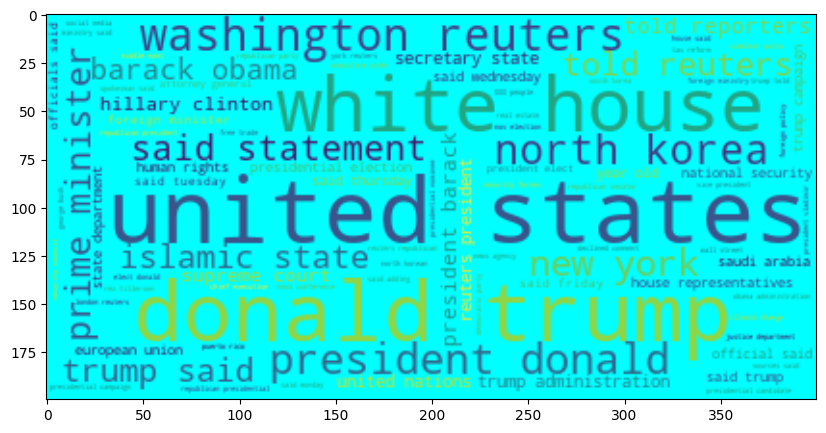

In [44]:
X_real_bi_df.T.sum(axis=1)
Cloud = WordCloud(background_color="cyan", max_words=100).generate_from_frequencies(X_real_bi_df.T.sum(axis=1))
plt.figure(figsize=(12,5))
plt.imshow(Cloud, interpolation='bilinear');

In [45]:
# trigram

In [46]:
cvec_trigram = CountVectorizer(ngram_range=(3, 3), stop_words='english', min_df =0.01)

In [47]:
X_real = real_df['text']
X_real_cvec_tri = cvec_trigram.fit_transform(X_real)

In [48]:
X_real_tri_df = pd.DataFrame(X_real_cvec_tri.toarray(), columns=cvec_trigram.get_feature_names())

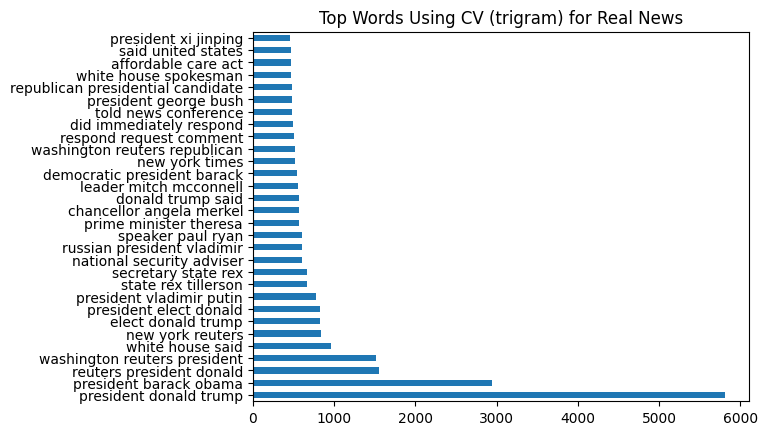

In [49]:
X_real_tri_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words Using CV (trigram) for Real News');

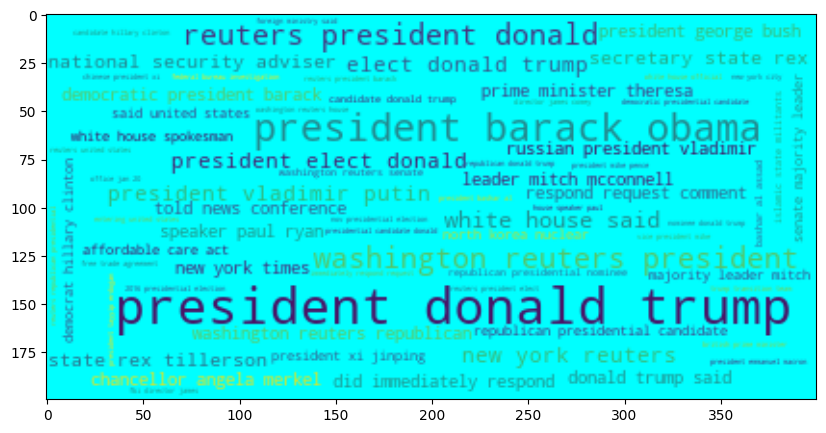

In [50]:
X_real_tri_df.T.sum(axis=1)
Cloud = WordCloud(background_color="cyan", max_words=100).generate_from_frequencies(X_real_tri_df.T.sum(axis=1))
plt.figure(figsize=(12,5))
plt.imshow(Cloud, interpolation='bilinear');

In [51]:
# Save cleaned dataframe as csv file.
real_df.to_csv('./datasets/real_1.csv', index=False)

#### Fake News

In [52]:
# Instantiate a CountVectorizer, excluding stopwords
cvec = CountVectorizer(stop_words='english', min_df = 0.01)

In [53]:
X_fake = fake_df['text']
X_fake_cvec = cvec.fit_transform(X_fake)

In [54]:
X_fake_df = pd.DataFrame(X_fake_cvec.toarray(), columns=cvec.get_feature_names())

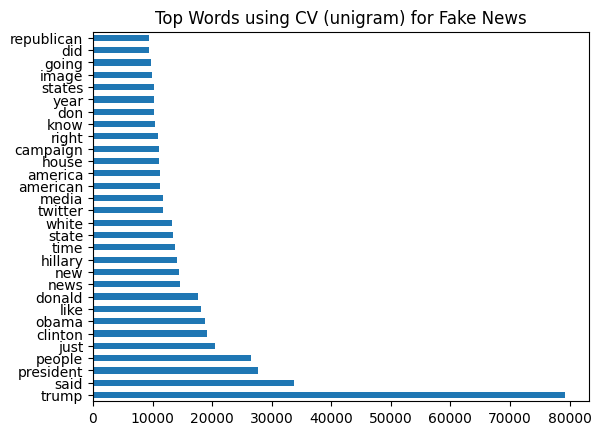

In [55]:
# plot top occuring words in a horizontal bar chart
X_fake_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (unigram) for Fake News', fontsize=12);

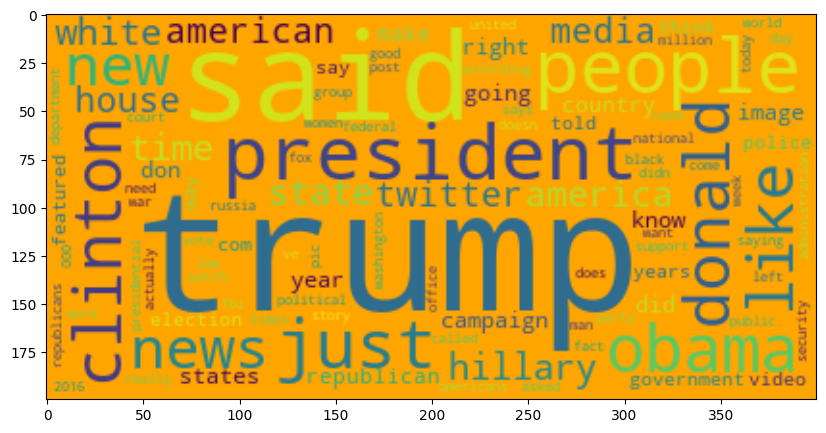

In [56]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
X_fake_df.T.sum(axis=1)
Cloud = WordCloud(background_color="orange", max_words=100).generate_from_frequencies(X_fake_df.T.sum(axis=1))
plt.figure(figsize=(12,5))
plt.imshow(Cloud, interpolation='bilinear');

In [57]:
# bigrams

In [58]:
cvec_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english', min_df =0.01)

In [59]:
X_fake = fake_df['text']
X_fake_cvec_bi = cvec_bigram.fit_transform(X_fake)

In [60]:
X_fake_bi_df = pd.DataFrame(X_fake_cvec_bi.toarray(), columns=cvec_bigram.get_feature_names())

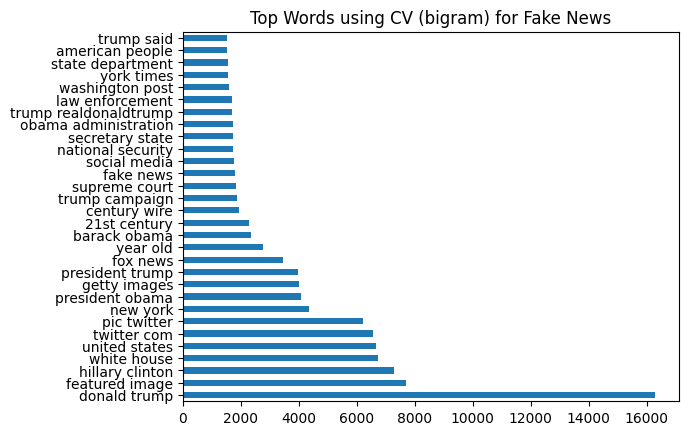

In [61]:
# plot top occuring words in a horizontal bar chart
X_fake_bi_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words using CV (bigram) for Fake News', fontsize=12);

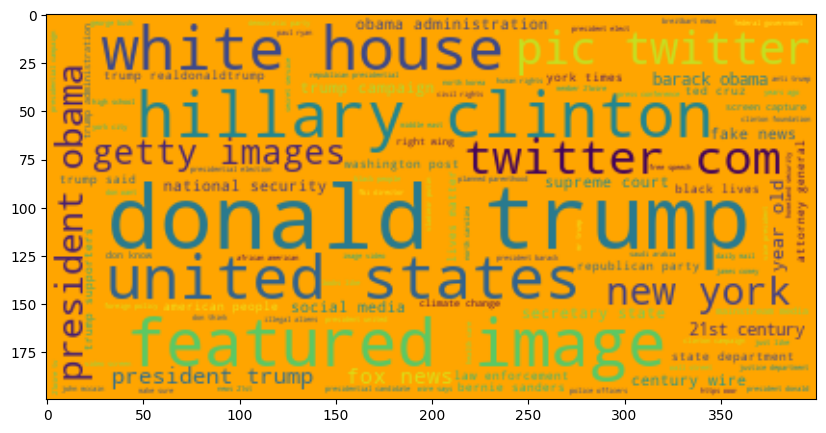

In [62]:
X_fake_bi_df.T.sum(axis=1)
Cloud = WordCloud(background_color="orange", max_words=100).generate_from_frequencies(X_fake_bi_df.T.sum(axis=1))
plt.figure(figsize=(12,5))
plt.imshow(Cloud, interpolation='bilinear');

In [63]:
# trigrams

In [64]:
cvec_trigram = CountVectorizer(ngram_range=(3, 3), stop_words='english', min_df =0.01)

In [65]:
X_fake = fake_df['text']
X_fake_cvec_tri = cvec_trigram.fit_transform(X_fake)

In [66]:
X_fake_tri_df = pd.DataFrame(X_fake_cvec_tri.toarray(), columns=cvec_trigram.get_feature_names())

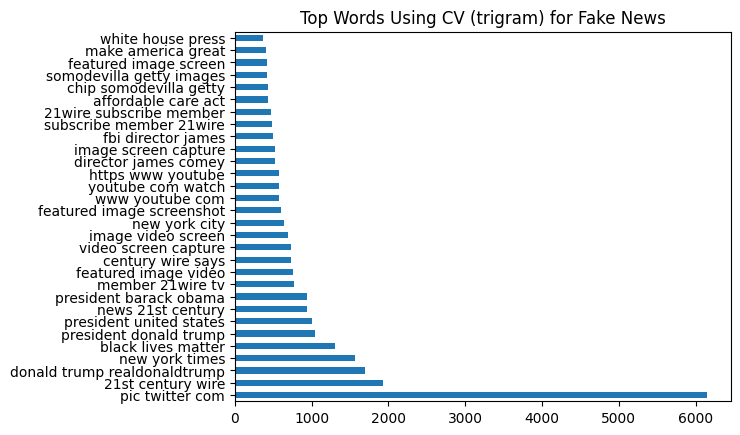

In [67]:
X_fake_tri_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")
plt.title('Top Words Using CV (trigram) for Fake News');

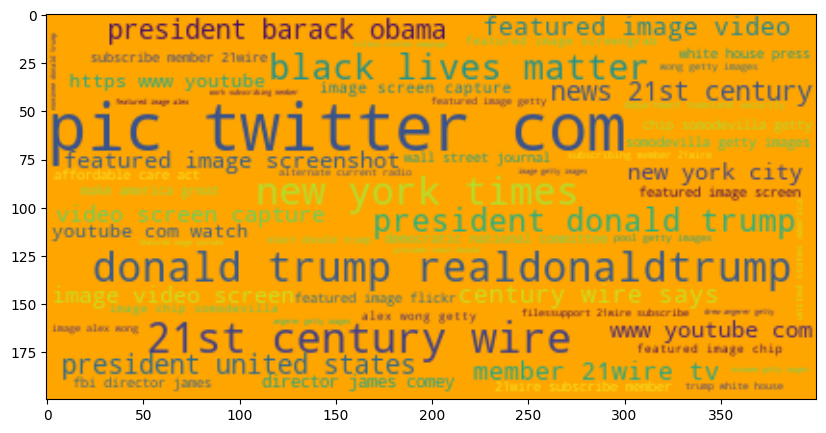

In [68]:
X_fake_tri_df.T.sum(axis=1)
Cloud = WordCloud(background_color="orange", max_words=100).generate_from_frequencies(X_fake_tri_df.T.sum(axis=1))
plt.figure(figsize=(12,5))
plt.imshow(Cloud, interpolation='bilinear');

Observation
- 'Reuters' is one of the top words in real news. This is likely because the real news were taken from 'Reuters'
- '21wire', '21st century wire', '21wiretv', 'twitter' and 'realdonaldtrump'are some of the common words found in the fake news dataset but not in the real news dataset. It is likely that these are the sources where the fake news originated. 
- 'image', 'video', 'youtube' and 'getty image' are common words in fake news. This is likely because the fake news article contains video or images links that are linked to getty image or youtube.
- Since these are obvious words that relates to real and fake news respectively, we will drop these words from the corpus by adding these words to the customised stopwords list.

## Feature Engineering (combining title and text)

The headline and text will be merged to form the text feature for modeling.

In [69]:
# combining 'text' and 'title' to form the dataframe
real_df['title_text'] = real_df['title'] + ' ' + real_df['text']
fake_df['title_text'] = fake_df['title'] + ' ' + fake_df['text']

In [70]:
# counting the total words after combining 'text' and 'title'
real_df['wordcount_total'] = real_df['title_text'].apply(lambda txt: len(txt.split()))
fake_df['wordcount_total'] = fake_df['title_text'].apply(lambda txt: len(txt.split()))

In [71]:
# labelling the data, classify fake news as `1` and real news as `0`
real_df['label'] = 0
fake_df['label'] = 1

In [72]:
real_df=real_df[['title', 'text', 'title_text', 'subject', 'date', 'wordcount_title', 'wordcount_text', 'wordcount_total','label']]
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21211 entries, 0 to 21210
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            21211 non-null  object        
 1   text             21211 non-null  object        
 2   title_text       21211 non-null  object        
 3   subject          21211 non-null  object        
 4   date             21211 non-null  datetime64[ns]
 5   wordcount_title  21211 non-null  int64         
 6   wordcount_text   21211 non-null  int64         
 7   wordcount_total  21211 non-null  int64         
 8   label            21211 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 1.5+ MB


In [73]:
fake_df=fake_df[['title', 'text', 'title_text', 'subject', 'date', 'wordcount_title', 'wordcount_text', 'wordcount_total', 'label']]
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23478 entries, 0 to 23477
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            23478 non-null  object        
 1   text             23478 non-null  object        
 2   title_text       23478 non-null  object        
 3   subject          23478 non-null  object        
 4   date             23468 non-null  datetime64[ns]
 5   wordcount_title  23478 non-null  int64         
 6   wordcount_text   23478 non-null  int64         
 7   wordcount_total  23478 non-null  int64         
 8   label            23478 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 1.6+ MB


## Combining Dataset

In [74]:
# Combine dataframes
combined_df = pd.concat([real_df, fake_df])

In [75]:
# Reset index of combined posts
combined_df.reset_index(drop=True, inplace=True)

In [76]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            44689 non-null  object        
 1   text             44689 non-null  object        
 2   title_text       44689 non-null  object        
 3   subject          44689 non-null  object        
 4   date             44679 non-null  datetime64[ns]
 5   wordcount_title  44689 non-null  int64         
 6   wordcount_text   44689 non-null  int64         
 7   wordcount_total  44689 non-null  int64         
 8   label            44689 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 3.1+ MB


In [77]:
# Check shape of dataframe
combined_df.shape

(44689, 9)

In [78]:
# Verify if the combined dataframe is a balanced dataset
combined_df['label'].value_counts(normalize=True)

1    0.525364
0    0.474636
Name: label, dtype: float64

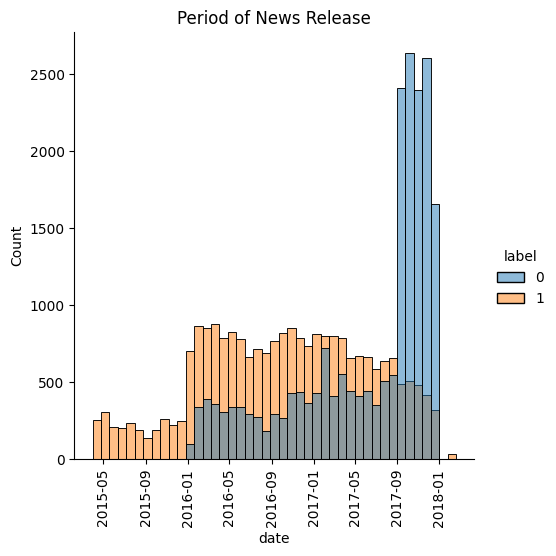

In [79]:
sns.displot(data=combined_df, x='date', hue='label')
plt.xticks(rotation='vertical')
plt.title("Period of News Release");

Observations:
- It is observed that in 2016 there was an influx of fake news. This is most likely attributed to the 2016 US Presidential Election event. Considering one of the key topic of fake news is on the subject of politics, it is reasonable that the Presidential Election would have caused the increase in the number of fake news  eing generated.
- The influx of real news in 2017 (in the dataset) is likely attributed to the source originator attempting to scrap more real news data to balance out the fake and real news datasets.

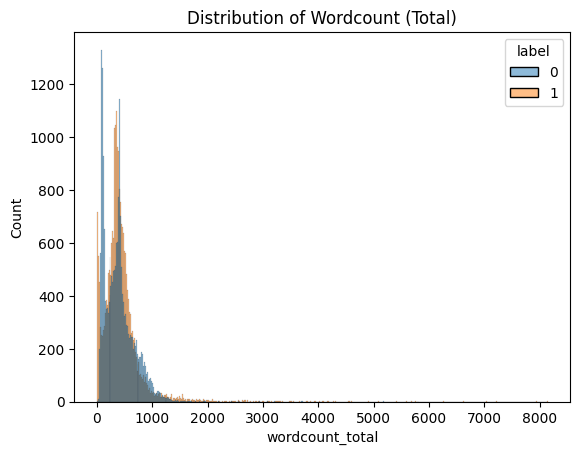

In [80]:
sns.histplot(data=combined_df, x='wordcount_total', hue='label')
plt.title('Distribution of Wordcount (Total)', fontsize=12);

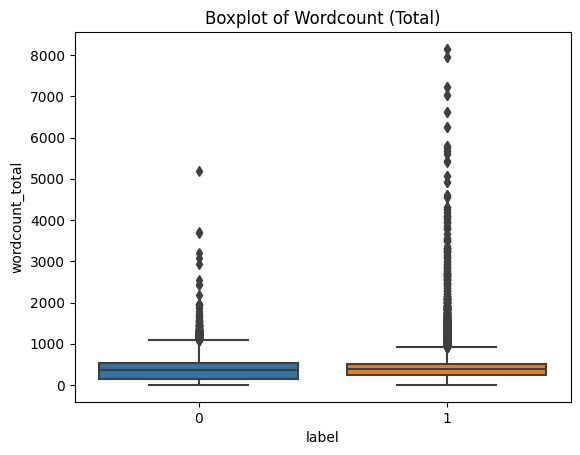

In [81]:
sns.boxplot(data=combined_df, y='wordcount_total', x='label')
plt.title('Boxplot of Wordcount (Total)', fontsize=12);

Observations:

- On average, headline word count length for real and fake news are 10 and 15 respectively. Average lebgth of the headline for fake news is longer than real news.
- On average, article word count length for real and fake news are 400 and 500 resectively. Fake articles tend to be longer than real news article.
- As observed from the boxplot, there are more outliers obserced for the article length for fake news. Unlike real news which are usually written by journalist backed up with a proper editorial setup, fake news tend to be contributed by non-trained writers of varying writing styles. As such, length of the article tend to have more outliers.
- For this project, outliers will be retained as having lengthy content length is a typical feature of a fake news article. The additional texts are useful text features for the modeling.

In [82]:
combined_df['year'] = pd.DatetimeIndex(combined_df['date']).year

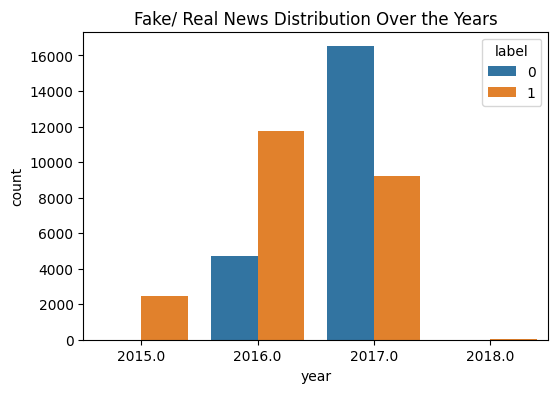

In [83]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=combined_df, x="year", hue="label")
plt.title('Fake/ Real News Distribution Over the Years', fontsize=12);

In [84]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            44689 non-null  object        
 1   text             44689 non-null  object        
 2   title_text       44689 non-null  object        
 3   subject          44689 non-null  object        
 4   date             44679 non-null  datetime64[ns]
 5   wordcount_title  44689 non-null  int64         
 6   wordcount_text   44689 non-null  int64         
 7   wordcount_total  44689 non-null  int64         
 8   label            44689 non-null  int64         
 9   year             44679 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 3.4+ MB


In [85]:
combined_df.head()

,title,text,title_text,subject,date,wordcount_title,wordcount_text,wordcount_total,label,year
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...","As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...",politicsNews,2017-12-31,10,749,759,0,2017.0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...","U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...",politicsNews,2017-12-29,9,624,633,0,2017.0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...","Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who se...",politicsNews,2017-12-31,10,457,467,0,2017.0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...","FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor...",politicsNews,2017-12-30,9,376,385,0,2017.0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight wi

In [86]:
# Save cleaned dataframe as csv file.
combined_df.to_csv('./datasets/combined_df.csv', index=False)

## Preprocessing of Text

In [87]:
## In this section, the 'title_text' column will be preprocessed prior to modelling.

In [88]:
# lower case the text
combined_df['lower_case'] = combined_df['title_text'].str.lower()

In [89]:
# remove website addresses from selftext_title column
# instantiate regex to identify and remove urls
combined_df['drop_url'] = combined_df['lower_case'].apply(lambda text: re.sub(r"http\S+", '', text))

In [90]:
# remove punctuations
combined_df['drop_punctuations'] = combined_df['drop_url'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

In [91]:
# tokenize
tokenizer = RegexpTokenizer(r"[\w']+") 
combined_df['tokenized'] = combined_df['drop_punctuations'].apply(lambda text: tokenizer.tokenize(text))

In [92]:
# Print English stopwords list from nltk library.
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [93]:
stopwords_list = stopwords.words("english")

# some words provided the source of the article, which may reveal explictly if the news is fake or real.Such words will be omitted to make the model less bias towards source
add_stopwords = ["21wire", "twitter", "reuters", '21WIRE', '21st', 'Century',  'Wire', 'somodevilla', 'getty', 'images', 'subscribe', 'member', 'realdonaldtrump']
stopwords_list.extend(add_stopwords)

In [94]:
# remove stopwords
combined_df['drop_stopwords'] = combined_df['tokenized'].apply(lambda value: [word for word in value if word not in stopwords_list])

In [95]:
# show combined_df, verify the pre-processing were as intended
combined_df[['title_text','lower_case', 'drop_url','drop_punctuations','tokenized', 'drop_stopwords']]

,title_text,lower_case,drop_url,drop_punctuations,tokenized,drop_stopwords
0,"As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...","as u.s. budget fight looms, republicans flip their fiscal script washington (reuters) - the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on sunday and urged budget restraint in 2018. in keeping with a sharp pivot under way among republicans, u.s. represe...","as u.s. budget fight looms, republicans flip their fiscal script washington (reuters) - the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on sunday and urged budget restraint in 2018. in keeping with a sharp pivot under way among republicans, u.s. represe...",as us budget fight looms republicans flip their fiscal script washington reuters the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in 2018 in keeping with a sharp pivot under way among republicans us representative mark mea...,"[as, us, budget, fight, looms, republicans, flip, their, fiscal, script, washington, reuters, the, head, of, a, conservative, republican, faction, in, the, us, congress, who, voted, this, month, for, a, huge, expansion, of, the, national, debt, to, pay, for, tax, cuts, called, himself, a, fiscal, conservative, on, sunday, and, urged, budget, restraint, in, 2018, in, keeping, with, a, sharp, pi...","[us, budget, fight, looms, republicans, flip, fiscal, script, washington, head, conservative, republican, faction, us, congress, voted, month, huge, expansion, national, debt, pay, tax, cuts, called, fiscal, conservative, sunday, urged, budget, restraint, 2018, keeping, sharp, pivot, way, among, republicans, us, representative, mark, meadows, speaking, cbs, face, nation, drew, hard, line, fede..."
1,"U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...","u.s. military to accept transgender recruits on monday: pentagon washington (reuters) - transgender people will be allowed for the first time to enlist in the u.s. military starting on monday as ordered by federal courts, the pentagon said on friday, after president donald trump’s administration decided not to appeal rulings that blocked his transgender ban. two federal appeals courts, one in ...","u.s. military to accept transgender recruits on monday: pentagon washington (reuters) - transgender people will be allowed for the first time to enlist in the u.s. military starting on monday as ordered by federal courts, the pentagon said on friday, after president donald trump’s administration decided not to appeal rulings that blocked his transgender ban. two federal appeals courts, one in ...",us military to accept transgender recruits on monday pentagon washington reuters transgender people will be allowed for the first time to enlist in the us military starting on monday as ordered by federal courts the pentagon said on friday after president donald trumps administration decided not to appeal

Text(0.5, 1.0, 'length of document after stop words removal')

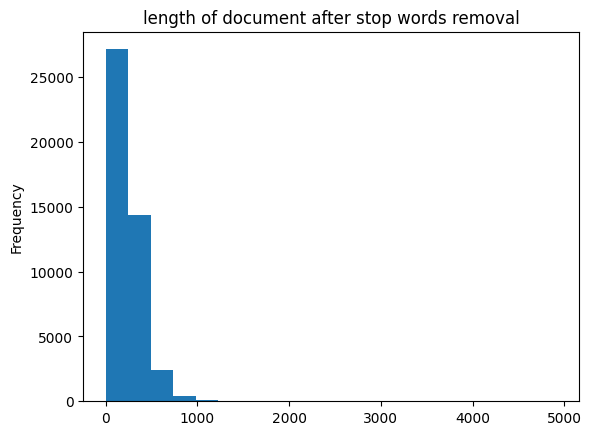

In [96]:
combined_df['length_of_sentence'] = combined_df['drop_stopwords'].apply(len)
combined_df['length_of_sentence'].plot(kind='hist', bins=20)
plt.title("length of document after stop words removal")

### Stemming / Lemmitization

In this section, stemming and lemmitization shall be applied to the text. 

In [97]:
# Instantiate Lemmatizer
lemmatizer = WordNetLemmatizer()
combined_df['lemmatizer'] = combined_df['drop_stopwords'].apply(lambda text:[lemmatizer.lemmatize(i) for i in text]) 

In [98]:
# Joining the list of words back into a string separated by space
combined_df['lemmatizer_join'] = combined_df['lemmatizer'].apply(lambda word: " ".join(word))

In [99]:
# Instantiate Stemming
p_stemmer = PorterStemmer()
combined_df['stemming'] = combined_df['drop_stopwords'].apply(lambda text:[p_stemmer.stem(i) for i in text]) 

In [100]:
# Joining the list of words back into a string separated by space
combined_df['stemming_join'] = combined_df['stemming'].apply(lambda word: " ".join(word))

In [101]:
combined_df[['title_text','lemmatizer','lemmatizer_join', 'stemming', 'stemming_join']]

,title_text,lemmatizer,lemmatizer_join,stemming,stemming_join
0,"As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...","[u, budget, fight, loom, republican, flip, fiscal, script, washington, head, conservative, republican, faction, u, congress, voted, month, huge, expansion, national, debt, pay, tax, cut, called, fiscal, conservative, sunday, urged, budget, restraint, 2018, keeping, sharp, pivot, way, among, republican, u, representative, mark, meadow, speaking, cbs, face, nation, drew, hard, line, federal, spe...",u budget fight loom republican flip fiscal script washington head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint 2018 keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holida...,"[us, budget, fight, loom, republican, flip, fiscal, script, washington, head, conserv, republican, faction, us, congress, vote, month, huge, expans, nation, debt, pay, tax, cut, call, fiscal, conserv, sunday, urg, budget, restraint, 2018, keep, sharp, pivot, way, among, republican, us, repres, mark, meadow, speak, cb, face, nation, drew, hard, line, feder, spend, lawmak, brace, battl, januari,...",us budget fight loom republican flip fiscal script washington head conserv republican faction us congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restraint 2018 keep sharp pivot way among republican us repres mark meadow speak cb face nation drew hard line feder spend lawmak brace battl januari return holiday wednesday lawmak begin tri pass feder bu...
1,"U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...","[u, military, accept, transgender, recruit, monday, pentagon, washington, transgender, people, allowed, first, time, enlist, u, military, starting, monday, ordered, federal, court, pentagon, said, friday, president, donald, trump, administration, decided, appeal, ruling, blocked, transgender, ban, two, federal, appeal, court, one, washington, one, virginia, last, week, rejected, administration...",u military accept transgender recruit monday pentagon washington transgender people allowed first time enlist u military starting monday ordered federal court pentagon said friday president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requ...,"[us, militari, accept, transgend, recruit, monday, pentagon, washington, transgend, peopl, allow, first, time, enlist, us, militari, start, monday, order, feder, court, pentagon, said, friday, presid, donald, trump, administr, decid, appeal, rule, block, transgend, ban, two, feder, appeal, court, one, washington, one, virginia, last, week, reject, administr, request, put, hold, order, lower, c...",us militari accept transgend recruit monday pentagon washington transgend peopl allow first time enlist us militari start monday order feder court pentagon said friday presid donald trump administr decid appeal rule block transgend ban two feder appeal court one washington one virginia last week reject administr request 

In [102]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               44689 non-null  object        
 1   text                44689 non-null  object        
 2   title_text          44689 non-null  object        
 3   subject             44689 non-null  object        
 4   date                44679 non-null  datetime64[ns]
 5   wordcount_title     44689 non-null  int64         
 6   wordcount_text      44689 non-null  int64         
 7   wordcount_total     44689 non-null  int64         
 8   label               44689 non-null  int64         
 9   year                44679 non-null  float64       
 10  lower_case          44689 non-null  object        
 11  drop_url            44689 non-null  object        
 12  drop_punctuations   44689 non-null  object        
 13  tokenized           44689 non-null  object    

Assessment: 
Stemming is a method of deriving root words from the inflected word. Since these root words does not carry semantic meaning and fake news prediction requires semantic meaning / comtext. Lemmatization where it converts the words into root words that have semantic meaning.

In [103]:
combined_df['classification_text'] = combined_df['lemmatizer_join']

In [104]:
# define dataframe for modelling (classification)
classification_df = combined_df[['date', 'title_text', 'classification_text', 'label']]

In [105]:
classification_df.rename(columns = {'title_text':'original_title_text'}, inplace = True)

C:\Users\alvintky89\AppData\Local\Temp\ipykernel_22456\3906892128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df.rename(columns = {'title_text':'original_title_text'}, inplace = True)


In [106]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 44679 non-null  datetime64[ns]
 1   original_title_text  44689 non-null  object        
 2   classification_text  44689 non-null  object        
 3   label                44689 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.4+ MB


In [107]:
classification_df

,date,original_title_text,classification_text,label
0,2017-12-31,"As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Represe...",u budget fight loom republican flip fiscal script washington head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint 2018 keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holida...,0
1,2017-12-29,"U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in ...",u military accept transgender recruit monday pentagon washington transgender people allowed first time enlist u military starting monday ordered federal court pentagon said friday president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requ...,0
2,2017-12-31,"Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who se...",senior u republican senator let mr mueller job washington special counsel investigation link russia president trump 2016 election campaign continue without interference 2018 despite call trump administration ally republican lawmaker shut prominent republican senator said sunday lindsey graham serf senate armed force judiciary committee said department justice special counsel robert mueller nee...,0
3,2017-12-30,"FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor...",fbi russia probe helped australian diplomat tipoff nyt washington trump campaign adviser george papadopoulos told australian diplomat may 2016 russia political dirt democratic presidential candidate hillary clinton new york time reported saturday conversation papadopoulos diplomat alexander downer london driving factor behind fbi decision open counterintelligence investigation moscow contact t...,0
4,2017-12-29,"Trump wants Postal Service to charge 'much more' for Amazon shipments SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a y...",trump want postal service charge much amazon shipment seattlewashington president donald trump called u postal service friday charge much ship package amazon amzno picking another fight online retail giant criticized past united state post office losing many billion do

## Save and export dataset

In [108]:
# Save cleaned dataframe as csv file.
classification_df.to_csv('./datasets/classification_df.csv', index=False)